# 基于RNN语言模型的诗句生成

欢迎大家来到这个有趣的实验！在这个实验中，大家将学使用PaddlePaddle实现循环神经网络模型（即RNN模型，以下循环神经网络都称作RNN）,并实现基于RNN语言模型进行诗句的生成，在这次实验中，利用全唐诗数据集对RNN语言模型进行训练，能够实现根据输入的前缀诗句，自动生成后续诗句。在这次实验中，你将跟随实验内容，探索诗句的生成过程。你还将加深对RNN模型的理解，并串联各个知识点，收获对RNN搭建与利用的整体把握。

** 你将学会 **

- 利用PaddlePaddle框架实现RNN模型

- 利用RNN语言模型进行诗句的生成

## 背景知识

RNN是一个序列模型，基本思路是：在时刻t，将前一时刻t−1的隐藏层输出和t时刻的词向量一起输入到隐藏层从而得到时刻t的特征表示，然后用这个特征表示得到t时刻的预测输出，如此在时间维上递归下去。可以看出RNN善于使用上文信息、历史知识，具有“记忆”功能。理论上RNN能实现“长依赖”（即利用很久之前的知识），但在实际应用中发现效果并不理想，研究提出了LSTM和GRU等变种，通过引入门机制对传统RNN的记忆单元进行了改进，弥补了传统RNN在学习长序列时遇到的难题。本次实验模型使用了LSTM或GRU，可通过配置进行修改。下图是RNN（广义上包含了LSTM、GRU等）语言模型“循环”思想的示意图：

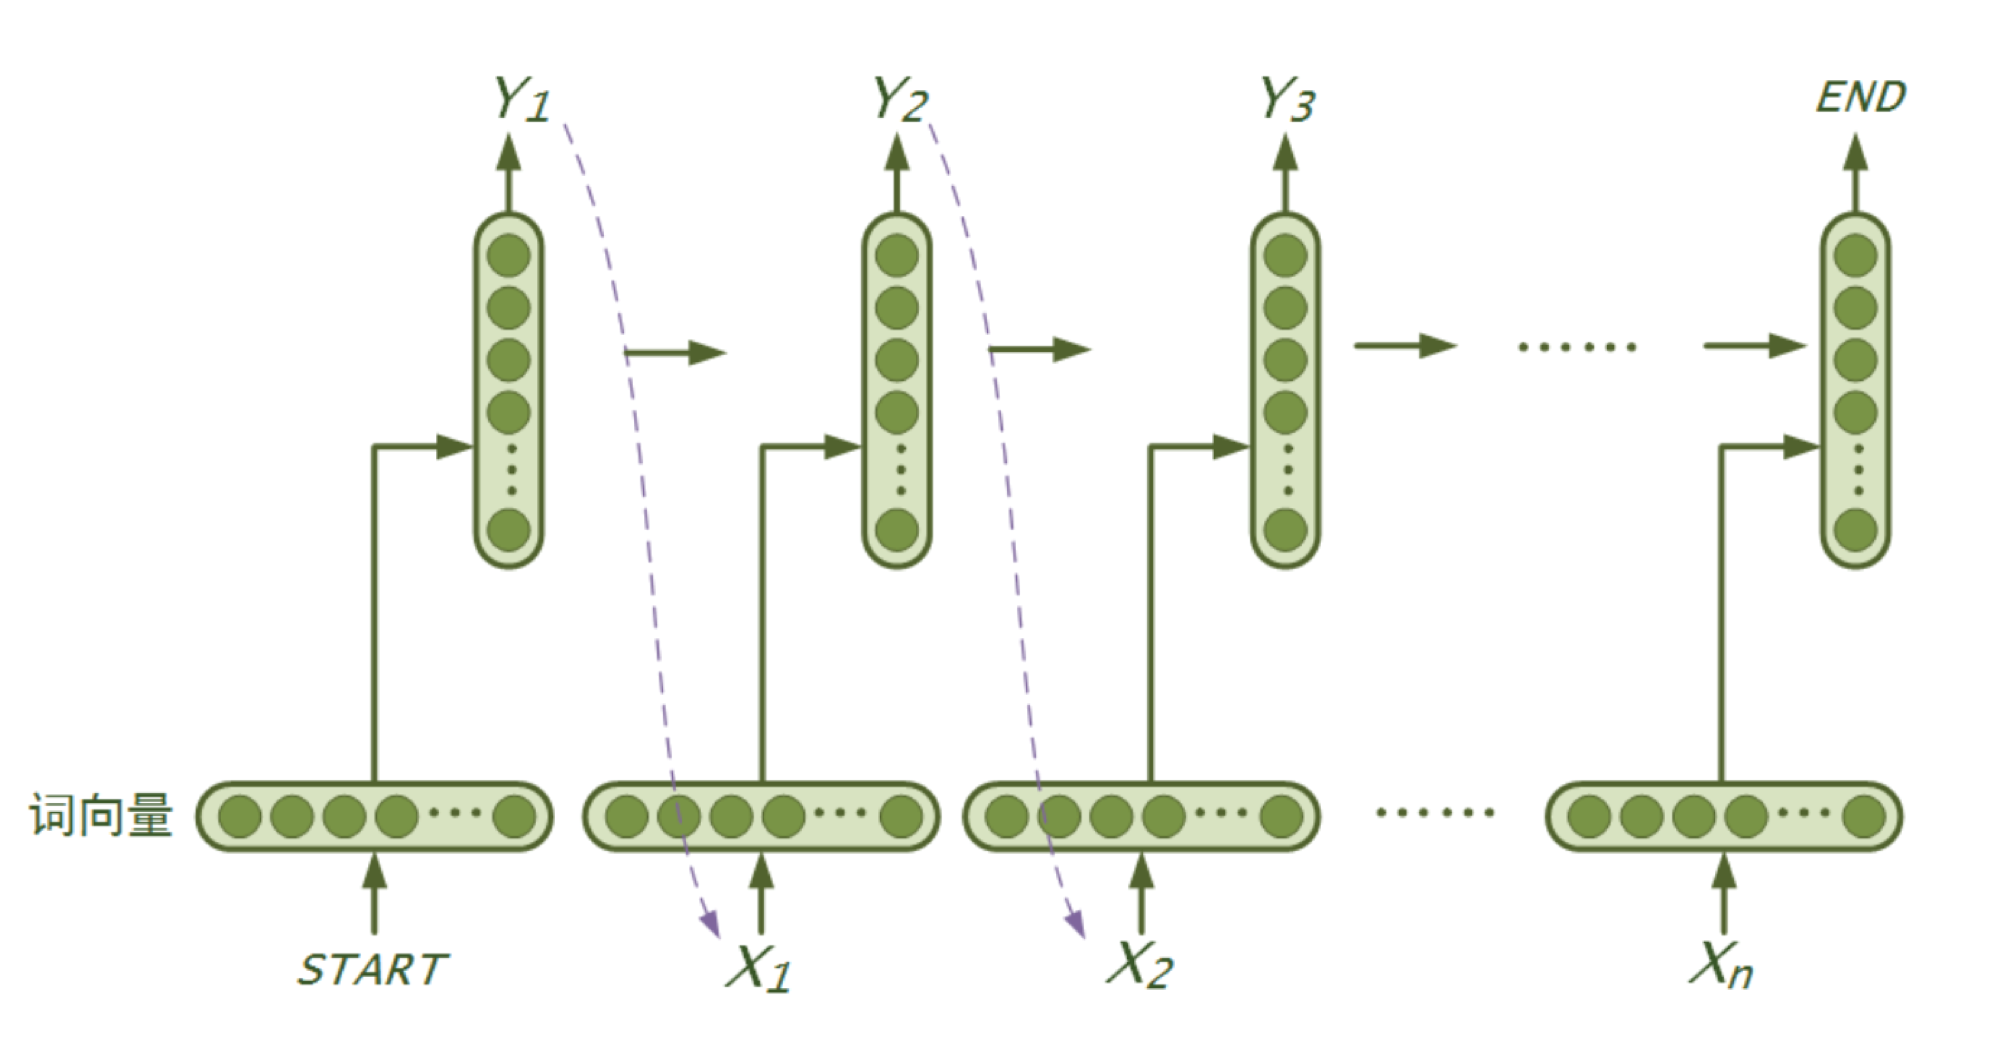

本实验要用到的RNN语言模型(Language Model)是一个概率分布模型，简单来说，就是用来计算一个句子的概率的模型。利用它可以确定生成的哪个词序列的可能性更大，或者给定若干个词，可以预测下一个最可能出现的词。基于RNN语言模型的特点，因此，我们打算利用该模型进行诗句的生成。

另外，语言模型也是自然语言处理领域里一个重要的基础模型。

简单了解以上原理后，我们就可以正式开始实验了。

## 1 - 引入库

首先，载入几个需要用到的库，它们分别是：

- os:用于获取文件或目录的路径
- sys:提供了一系列有关Python运行环境的变量和函数
- gzip:用于文件压缩与解压缩
- collections:包含了一些特殊的容器，针对python内置容器，如list、dict、set和tuple,提供了另一种选择
- logging:一个python内置标准库，用于输出运行日志
- numpy：一个python的基本库，用于科学计算
- math:用于实现多种数学运算

- paddle.v2：PaddlePaddle深度学习框架


In [1]:
import os
import sys
import gzip
import collections
import logging
from collections import defaultdict
import numpy as np
import math
import config as conf  #config.py中定义了模型的参数变量

import paddle.v2 as paddle

在这里，我们先了解一下logging包，logging包用来输出运行日志，其默认对输出分成了6个等级：

**各个等级：**: 
<table style="width:35%">
  <tr>
    <td>**Level**</td>
    <td> Numeric value </td> 
  </tr>
  
  <tr>
    <td>**CRITICAL**</td>
    <td> 50 </td> 
  </tr>
  
  <tr>
    <td>**ERROR**</td>
    <td> 40 </td> 
  </tr>
  
  <tr>
    <td>**WARNING**</td>
    <td> 30 </td> 
  </tr>
  
  <tr>
    <td>**INFO**</td>
    <td> 20 </td> 
  </tr>
  
  <tr>
    <td>**DEBUG**</td>
    <td> 10 </td> 
  </tr>
  
  <tr>
    <td>**NOTSET**</td>
    <td> 0 </td> 
  </tr>
  
</table>







   这里的分值就代表了相应关键字出现的等级高低，NOTSET最低，CRITICAL最高。高等级的语句会覆盖低等级的语句。
例如一般我们用logging的时候会先在主程序配置一个logging类的格式，然后在子程序中直接引用即可。如果我们在设置默认格式的时候设置的等级比之后调用是的要高，那么调用的logging语句将不会输出；反之，输出时默认等级也会被调用语句的等级覆盖。

In [2]:
#设置默认logging配置
logger = logging.getLogger("paddle")
logger.setLevel(logging.DEBUG)

## 2 - 数据预处理

这里简单介绍数据集及其结构。本实验使用的全唐诗数据集，数据集以txt文件的形式存储，已经过以下初步处理并直接提供。

- 清洗语料：去除了数据集中的诗的标题、标点符号、注释、乱码及特殊符号等。
- 内容格式：每首诗占一行；每行中的各个字之间使用一个空格符分开。

数据集样式为：

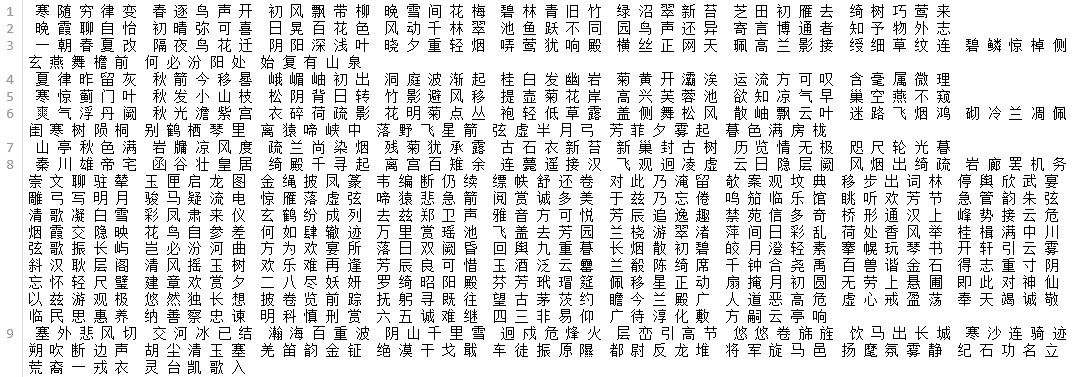

了解了这些之后，我们要将数据集转化成一系列词序列，以为训练做准备：

### 定义构建字典函数

当指定的字典文件不存在时，将对训练数据进行词频统计，并按词频排序，构建字典。

在构建字典函数build_dict()中，各参数介绍如下：

   **data_file:**         path of data file
   
   **type data_file:**         str
    
   **save_path:**         path to save the word dictionary
    
   **type save_path:**          str
    
   **vocab_max_size:**      if vocab_max_size is set, top vocab_max_size words
                          will be added into word vocabulary
                        
   **type vocab_max_size:**       int
    
   **cutoff_thd:**         if cutoff_thd is set, words whose frequencies are less than cutoff_thd will not be added into word                             vocabulary.
                         
        
   **type cutoff_word_fre:**      int
    
   **extra_keys:**         extra keys defined by users that added into the word dictionary, ususally these keys include <unk>,                             start and ending marks
    
   **type extra_keys:**          list
   
   


In [3]:
#定义构建字典函数
def build_dict(data_file,
               save_path,
               max_word_num,
               cutoff_word_fre=5,
               insert_extra_words=["<unk>", "<e>"]):
    #使用defaultdict()任何未定义的key都会默认返回一个默认值，避免在使用不存在的key时dict()返回KeyError的问题。
    word_count = defaultdict(int)
    with open(data_file, "r") as f:
        for idx, line in enumerate(f):
            if not (idx + 1) % 100000:
                logger.debug("processing %d lines ... " % (idx + 1))
            words = line.strip().lower().split()
            for w in words:
                word_count[w] += 1
    #将字按字频排序
    sorted_words = sorted(
        word_count.iteritems(), key=lambda x: x[1], reverse=True)

    stop_pos = len(sorted_words) if sorted_words[-1][
        1] > cutoff_word_fre else next(idx for idx, v in enumerate(sorted_words)
                                       if v[1] < cutoff_word_fre)

    stop_pos = min(max_word_num, stop_pos)
    with open(save_path, "w") as fdict:
        for w in insert_extra_words:
            fdict.write("%s\t-1\n" % (w))
        for idx, info in enumerate(sorted_words):
            if idx == stop_pos: break
            fdict.write("%s\t%d\n" % (info[0], info[-1]))


### 定义加载字典函数
加载字典函数中，各参数介绍如下：

   **dict_path:** path of word dictionary
   
   **type dict_path:** str
   
   **return:** the dictionary
   
   **rtype:** dict

In [4]:
#定义加载字典函数
def load_dict(dict_path):
    """
    load word dictionary from the given file. Each line of the give file is
    a word in the word dictionary. The first column of the line, seperated by
    TAB, is the key, while the line index is the value.

    """
    return dict((line.strip().split("\t")[0], idx)
                for idx, line in enumerate(open(dict_path, "r").readlines()))


def load_reverse_dict(dict_path):
    """
    load word dictionary from the given file. Each line of the give file is
    a word in the word dictionary. The line index is the key, while the first
    column of the line, seperated by TAB, is the value.

    """
    return dict((idx, line.strip().split("\t")[0])
                for idx, line in enumerate(open(dict_path, "r").readlines()))


### Beam Search 算法实现
   
请根据个人需要，可以选择参考[柱搜索算法](https://github.com/PaddlePaddle/book/blob/develop/08.machine_translation/README.cn.md#%E6%9F%B1%E6%90%9C%E7%B4%A2%E7%AE%97%E6%B3%95)介绍，来了解柱搜索算法（beam search),后续会利用柱搜索算法根据前缀生成文本。

这里给出BeamSearch类的定义。

In [5]:
#定义BeamSearch类
class BeamSearch(object):
    """
    Generating sequence by beam search   
    NOTE: this class only implements generating one sentence at a time.
    """

    def __init__(self, inferer, word_dict_file, beam_size=1, max_gen_len=100):
        """
        constructor method.

        :param inferer: object of paddle.Inference that represents the entire
            network to forward compute the test batch
        :type inferer: paddle.Inference
        :param word_dict_file: path of word dictionary file 
        :type word_dict_file: str
        :param beam_size: expansion width in each iteration 
        :type param beam_size: int
        :param max_gen_len: the maximum number of iterations 
        :type max_gen_len: int
        """
        self.inferer = inferer
        self.beam_size = beam_size
        self.max_gen_len = max_gen_len
        self.ids_2_word = load_reverse_dict(word_dict_file)
        logger.info("dictionay len = %d" % (len(self.ids_2_word)))

        try:
            self.eos_id = next(x[0] for x in self.ids_2_word.iteritems()
                               if x[1] == "<e>")
            self.unk_id = next(x[0] for x in self.ids_2_word.iteritems()
                               if x[1] == "<unk>")
        except StopIteration:
            logger.fatal(("the word dictionay must contain an ending mark "
                          "in the text generation task."))

        self.candidate_paths = []
        self.final_paths = []

    def _top_k(self, softmax_out, k):
        """
        get indices of the words with k highest probablities.
        NOTE: <unk> will be excluded if it is among the top k words, then word
        with (k + 1)th highest probability will be returned.

        :param softmax_out: probablity over the dictionary
        :type softmax_out: narray
        :param k: number of word indices to return
        :type k: int
        :return: indices of k words with highest probablities.
        :rtype: list
        """
        ids = softmax_out.argsort()[::-1]
        return ids[ids != self.unk_id][:k]

    def _forward_batch(self, batch):
        """
        forward a test batch.

        :params batch: the input data batch
        :type batch: list
        :return: probablities of the predicted word
        :rtype: ndarray
        """
        return self.inferer.infer(input=batch, field=["value"])

    def _beam_expand(self, next_word_prob):
        """
        In every iteration step, the model predicts the possible next words.
        For each input sentence, the top k words is added to end of the original
        sentence to form a new generated sentence.

        :param next_word_prob: probablities of the next words
        :type next_word_prob: ndarray
        :return:  the expanded new sentences.
        :rtype: list
        """
        assert len(next_word_prob) == len(self.candidate_paths), (
            "Wrong forward computing results!")
        top_beam_words = np.apply_along_axis(self._top_k, 1, next_word_prob,
                                             self.beam_size)
        new_paths = []
        for i, words in enumerate(top_beam_words):
            old_path = self.candidate_paths[i]
            for w in words:
                log_prob = old_path["log_prob"] + math.log(next_word_prob[i][w])
                gen_ids = old_path["ids"] + [w]
                if w == self.eos_id:
                    self.final_paths.append({
                        "log_prob": log_prob,
                        "ids": gen_ids
                    })
                else:
                    new_paths.append({"log_prob": log_prob, "ids": gen_ids})
        return new_paths

    def _beam_shrink(self, new_paths):
        """
        to return the top beam_size generated sequences with the highest
        probabilities at the end of evey generation iteration.

        :param new_paths: all possible generated sentences
        :type new_paths: list
        :return: a state flag to indicate whether to stop beam search
        :rtype: bool
        """

        if len(self.final_paths) >= self.beam_size:
            max_candidate_log_prob = max(
                new_paths, key=lambda x: x["log_prob"])["log_prob"]
            min_complete_path_log_prob = min(
                self.final_paths, key=lambda x: x["log_prob"])["log_prob"]
            if min_complete_path_log_prob >= max_candidate_log_prob:
                return True

        new_paths.sort(key=lambda x: x["log_prob"], reverse=True)
        self.candidate_paths = new_paths[:self.beam_size]
        return False

    def gen_a_sentence(self, input_sentence):
        """
        generating sequence for an given input

        :param input_sentence: one input_sentence
        :type input_sentence: list
        :return: the generated word sequences
        :rtype: list
        """
        self.candidate_paths = [{"log_prob": 0., "ids": input_sentence}]
        input_len = len(input_sentence)

        for i in range(self.max_gen_len):
            next_word_prob = self._forward_batch(
                [[x["ids"]] for x in self.candidate_paths])
            new_paths = self._beam_expand(next_word_prob)

            min_candidate_log_prob = min(
                new_paths, key=lambda x: x["log_prob"])["log_prob"]

            path_to_remove = [
                path for path in self.final_paths
                if path["log_prob"] < min_candidate_log_prob
            ]
            for p in path_to_remove:
                self.final_paths.remove(p)

            if self._beam_shrink(new_paths):
                self.candidate_paths = []
                break

        gen_ids = sorted(
            self.final_paths + self.candidate_paths,
            key=lambda x: x["log_prob"],
            reverse=True)[:self.beam_size]
        self.final_paths = []

        def _to_str(x):
            text = " ".join(self.ids_2_word[idx]
                            for idx in x["ids"][input_len:])
            return "%.4f\t%s" % (x["log_prob"], text)

        return map(_to_str, gen_ids)


## 3- 训练过程

本例中RNN语言模型的实现简介如下：

**定义模型参数：** config.py中定义了模型的参数变量，需要调整一些模型参数变量可在config.py文件中修改。

**定义模型结构：**以下构建的rnn_lm函数中定义了模型的结构，如下：

   - **输入层：**将输入的词（或字）序列映射成向量，即词向量层： embedding。

   - **中间层：**根据配置实现RNN层，将上一步得到的embedding向量序列作为输入。

   - **输出层：**使用softmax归一化计算单词的概率。

   - **loss：**定义多类交叉熵作为模型的损失函数。
   
   
   rnn_lm 函数中，各参数介绍如下：
   
   **vocab_dim:** size of vocabulary.
   
   **type vocab_dim:** int
   
   **emb_dim:** dimension of the embedding vector
   
   **type emb_dim:** int
   
   **rnn_type:** the type of RNN cell.
   
   **type rnn_type:** int
   
   **hidden_size:** number of hidden unit.
   
   **type hidden_size:** int
   
   **stacked_rnn_num:** number of stacked rnn cell.
   
   **type stacked_rnn_num:** int
   
   **return:** cost and output layer of model.
   
   **rtype:** LayerOutput
   




In [6]:
#定义RNN网络结构函数
def rnn_lm(vocab_dim,
           emb_dim,
           hidden_size,
           stacked_rnn_num,
           rnn_type="lstm",
           is_infer=False):
    """
    RNN language model definition.

    """
    
    # 定义输入层，input layers
    input = paddle.layer.data(
        name="input", type=paddle.data_type.integer_value_sequence(vocab_dim))
    if not is_infer:
        target = paddle.layer.data(
            name="target",
            type=paddle.data_type.integer_value_sequence(vocab_dim))

    # 定义词向量层，embedding layer
    input_emb = paddle.layer.embedding(input=input, size=emb_dim)

    # 定义 RNN 层，预先提供“lstm"与"gru"两种类别的RNN，可在配置文件中选择 rnn layer
    if rnn_type == "lstm":                                                    #本实验使用的是lstm
        for i in range(stacked_rnn_num):
            rnn_cell = paddle.networks.simple_lstm(
                input=rnn_cell if i else input_emb, size=hidden_size)
    elif rnn_type == "gru":
        for i in range(stacked_rnn_num):
            rnn_cell = paddle.networks.simple_gru(
                input=rnn_cell if i else input_emb, size=hidden_size)
    else:
        raise Exception("rnn_type error!")

    # 定义全连接输出层，fc(full connected) and output layer
    output = paddle.layer.fc(input=[rnn_cell],
                             size=vocab_dim,
                             act=paddle.activation.Softmax())

    if is_infer:
        last_word = paddle.layer.last_seq(input=output)
        return last_word
    else:
        cost = paddle.layer.classification_cost(input=output, label=target)    #定义损失函数

        return cost


    


**训练模型：**下面通过main方法实现了模型的训练，实现流程如下：

   - **准备输入数据：** 构建train和test数据的reader。
   
   
   
rnn_reader函数中，各参数介绍如下：
   
   **file_name:** file name.
   
   **word_dict:** vocab with content of '{word, id}','word' is string type , 'id' is int type.
   
   **return:** data reader.
   

In [7]:
# 限定读取文本的最短长度 sentence's min length.
MIN_LEN = 3

# 限定读取文本的最长长度 sentence's max length.
MAX_LEN = 100

# 定义RNNreader
def rnn_reader(file_name, word_dict):
    """
    create reader for RNN, each line is a sample.

    """

    def reader():
        UNK_ID = word_dict['<unk>']
        with open(file_name) as file:
            for line in file:
                words = line.strip().lower().split()
                if len(words) < MIN_LEN or len(words) > MAX_LEN:
                    continue
                ids = [word_dict.get(w, UNK_ID)
                       for w in words] + [word_dict['<e>']]
                yield ids[:-1], ids[1:]

    return reader


  - **定义模型训练函数**
  
       - **1 初始化模型：**包括模型的结构、参数。
   
       - **2 构建训练器：**本次实验中使用的是Adam优化算法。

       - **3 定义回调函数：**构建event_handler来跟踪训练过程中loss的变化，并在每轮训练结束时保存模型的参数。

模型训练函数train()中，各参数介绍如下：

   **topology:** cost layer of the model to train.
   
   **type topology:** LayerOuput
   
   **train_reader:** train data reader.
   
   **type trainer_reader:** collections.Iterable
   
   **test_reader:** test data reader.
   
   **type test_reader:** collections.Iterable
   
   **model_save_dir:** path to save the trained model
   
   **type model_save_dir:** str
   
   **num_passes:** number of epoch
   
   **type num_passes:** int


In [8]:
# 定义模型训练函数
def train(topology,
          train_reader,
          test_reader,
          model_save_dir="models",
          num_passes=10):
    """
    train model.

    """
    # 创建训练模型参数保存目录
    if not os.path.exists(model_save_dir):
        os.mkdir(model_save_dir)

    # 初始化 PaddlePaddle  
    paddle.init(use_gpu=conf.use_gpu, trainer_count=conf.trainer_count)

    # 创建 optimizer，使用Adam优化算法
    adam_optimizer = paddle.optimizer.Adam(
        learning_rate=1e-3,
        regularization=paddle.optimizer.L2Regularization(rate=1e-3),
        model_average=paddle.optimizer.ModelAverage(
            average_window=0.5, max_average_window=10000))      

    # 创建 parameters
    parameters = paddle.parameters.create(topology)
    
    # 创建 sum evaluator
    sum_eval = paddle.evaluator.sum(topology)
    
    # 创建 trainer 其中paddle.trainer.SGD() 函数定义一个随机梯度下降trainer，
    # 配置4个参数cost、parameters、update_equation、extra_layers，它们分别表示损失函数、参数、更新公式以及评估器。
    trainer = paddle.trainer.SGD(cost=topology,
                                 parameters=parameters,
                                 update_equation=adam_optimizer,
                                 extra_layers=sum_eval)

    # 定义 event_handler 以打印训练进度 
    def event_handler(event):
        if isinstance(event, paddle.event.EndIteration):
            # 每隔一个 log_period 打印一下训练信息
            if not event.batch_id % conf.log_period:
                logger.info("Pass %d, Batch %d, Cost %f, %s" % (
                    event.pass_id, event.batch_id, event.cost, event.metrics))

            #每隔一个 log_period 保存一次训练模型参数    
            if (not event.batch_id %
                    conf.save_period_by_batches) and event.batch_id:
                save_name = os.path.join(model_save_dir,
                                         "rnn_lm_pass_%05d_batch_%03d.tar.gz" %
                                         (event.pass_id, event.batch_id))
                with gzip.open(save_name, "w") as f:
                    trainer.save_parameter_to_tar(f)

        if isinstance(event, paddle.event.EndPass):
            if test_reader is not None:
                result = trainer.test(reader=test_reader)
                logger.info("Test with Pass %d, %s" %
                            (event.pass_id, result.metrics))
            save_name = os.path.join(model_save_dir, "rnn_lm_pass_%05d.tar.gz" %
                                     (event.pass_id))
            with gzip.open(save_name, "w") as f:
                trainer.save_parameter_to_tar(f)
    # 输出训练运行日志
    logger.info("start training...")
    trainer.train(
        reader=train_reader, event_handler=event_handler, num_passes=num_passes)

    logger.info("Training is finished.")




- **进行训练工作**

    - **1 准备词典文件**
   
    - **2 读取数据**

    - **3 调用上面已经定义的模型训练函数train（），开始训练**

In [ ]:
# 进行训练工作

def main():
    # 构建并加载词典文件 
    if not (os.path.exists(conf.vocab_file) and
            os.path.getsize(conf.vocab_file)):
        logger.info(("word dictionary does not exist, "
                     "build it from the training data"))
        build_dict(conf.train_file, conf.vocab_file, conf.max_word_num,
                   conf.cutoff_word_fre)
    logger.info("load word dictionary.")
    word_dict = load_dict(conf.vocab_file)
    logger.info("dictionay size = %d" % (len(word_dict)))

    cost = rnn_lm(
        len(word_dict), conf.emb_dim, conf.hidden_size, conf.stacked_rnn_num,
        conf.rnn_type)

    # 使用 reader 
    reader_args = {
        "file_name": conf.train_file,
        "word_dict": word_dict,
    }
    # paddle.reader.shuffle(train(), buf_size=102400)表示trainer从 rnn_reader 中读取了 buf_size=102400大小的数据并打乱顺序
    # batch_size 表示从打乱的数据中再取出 batch_size=con.batch_size 大小的数据进行一次迭代训练
    train_reader = paddle.batch(
        paddle.reader.shuffle(
            rnn_reader(**reader_args), buf_size=102400),
        batch_size=conf.batch_size)
    test_reader = None
    if os.path.exists(conf.test_file) and os.path.getsize(conf.test_file):
        test_reader = paddle.batch(
            paddle.reader.shuffle(
                rnn_reader(**reader_args), buf_size=65536),
            batch_size=conf.batch_size)
    # 正式开始训练,相关参数调用自 config.py 文件
    train(
        topology=cost,
        train_reader=train_reader,
        test_reader=test_reader,
        model_save_dir=conf.model_save_dir,
        num_passes=conf.num_passes)



main()


[INFO 2018-03-31 15:30:09,848 <ipython-input-9-a277b2b1d241>:11] load word dictionary.
[INFO 2018-03-31 15:30:09,866 <ipython-input-9-a277b2b1d241>:13] dictionay size = 7541
[INFO 2018-03-31 15:30:10,283 <ipython-input-8-6094b4adb8d2>:65] start training...
[INFO 2018-03-31 15:30:11,864 <ipython-input-8-6094b4adb8d2>:44] Pass 0, Batch 0, Cost 417.387146, {'__sum_evaluator_0__': 8.928067207336426, 'classification_error_evaluator': 0.999331533908844}


**补充说明：**

需要注意的是，词典越大生成的内容越丰富，但训练耗时越久。对于普通文本内容，一般中文分词之后，语料中不同的词可能会数以万计，如果

max_word_num 取值过小则导致<unk>占比过高，如果 max_word_num 取值较大，则严重影响训练速度（对精度也有影响）。所以，也有“按字”训练模型的方
    
 式，即：把每个汉字当做一个词，常用汉字也就几千个，使得字典的大小不会太大、不会丢失太多信息，本实验中，全唐诗数据集选择采取了按字训练的方式。

## 4 - 生成诗句文本

**定义生成诗句函数，rnn_generate() 实现了诗句的生成，实现流程如下：**

 - 加载训练好的模型和词典文件。
 
 - 读取gen_file文件，每行是一个句子的前缀，用柱搜索算法(Beam Search)根据前缀生成文本。
 
 - 将生成的文本及其前缀保存到文件gen_result。



rnn_generate() 函数中，各参数介绍如下：

 **word_id_dict:** vocab.
 
 **type word_id_dict:** dictionary with content of "{word, id}", "word" is string type , "id" is int type.
 
 **num_words:** the number of the words to generate.
 
 **type num_words:** int
 
 **beam_size:** beam width.
    
 **type beam_size:** int
    
 **return:** save prediction results to output_file


In [ ]:
# 定义生成诗句函数
def rnn_generate(gen_input_file, model_path, max_gen_len, beam_size,
                 word_dict_file):
    """
    use RNN model to generate sequences.

    """

    assert os.path.exists(gen_input_file), "test file does not exist!"
    assert os.path.exists(model_path), "trained model does not exist!"
    assert os.path.exists(
        word_dict_file), "word dictionary file does not exist!"

    # 加载词典文件
    word_2_ids = load_dict(word_dict_file)
    try:
        UNK_ID = word_2_ids["<unk>"]
    except KeyError:
        logger.fatal("the word dictionary must contain a <unk> token!")
        sys.exit(-1)

    # 初始化 PaddlePaddle
    paddle.init(use_gpu=conf.use_gpu, trainer_count=conf.trainer_count)

    # 加载训练好的模型
    pred_words = rnn_lm(
        len(word_2_ids),
        conf.emb_dim,
        conf.hidden_size,
        conf.stacked_rnn_num,
        conf.rnn_type,
        is_infer=True)
    # 使用训练完成的模型参数
    parameters = paddle.parameters.Parameters.from_tar(
        gzip.open(model_path, "r"))

    inferer = paddle.inference.Inference(
        output_layer=pred_words, parameters=parameters)

    generator = BeamSearch(inferer, word_dict_file, beam_size, max_gen_len)
    # 生成诗句文本
    with open(conf.gen_file, "r") as fin, open(conf.gen_result, "w") as fout:
        for idx, line in enumerate(fin):
            fout.write("%d\t%s" % (idx, line))
            for gen_res in generator.gen_a_sentence([
                    word_2_ids.get(w, UNK_ID)
                    for w in line.lower().strip().split()
            ]):
                fout.write("%s\n" % gen_res)
            fout.write("\n")



rnn_generate(conf.gen_file, conf.model_path, conf.max_gen_len,
                 conf.beam_size, conf.vocab_file)


**生成诗句输出展示：**

In [1]:
# 查看看一下生成的诗句效果
print("生成诗句展示：\n")
for i in open("data/gen_result.txt"):
    print i


生成诗句展示：

0	黄 河 远 上 白 云 间

-12.4769	今 日 逢 君 泪 满 缨

-12.7528	今 日 逢 君 泪 满 衣

-13.8208	今 日 逢 君 泪 满 巾

-13.8563	今 日 将 军 汉 水 边

-14.0999	今 日 逢 君 不 见 春



1	羌 笛 何 须 怨 杨 柳

-8.9801	不 知 何 处 草 萋 萋

-9.3334	不 知 何 处 是 春 风

-10.4879	不 知 何 处 是 花 枝

-11.1031	不 知 人 不 知 何 人

-11.2889	不 知 何 处 是 春 山



2	无 边 落 木 萧 萧 下

-12.0765	日 暮 孤 舟 何 处 来

-12.5019	独 自 撄 宁 逆 鼓 鼙

-13.0668	日 暮 孤 舟 何 处 期

-13.7688	日 暮 孤 舟 何 处 村

-13.8054	日 暮 孤 舟 何 处 寻



3	凤 凰 台 上 凤 凰 游

-14.9325	年 少 恩 深 万 岁 同

-14.9472	年 少 恩 华 事 可 知

-15.1605	年 少 恩 深 万 里 馀

-15.1802	年 少 恩 深 万 里 同

-15.1948	年 少 恩 深 万 里 人



4	日 出 江 花 红 胜 火-10.9732	春 风 袅 袅 百 花 枝

-11.9631	春 风 袅 袅 春 风 起

-12.2523	春 风 袅 袅 满 池 塘

-12.8227	春 风 袅 袅 百 花 时

-12.9489	春 风 袅 袅 百 花 飞





# 5 - 实验总结

实验已经实现根据提供的前缀诗句生成后续诗句的工作，到这里就结束了，让我们来回顾一下整体实验流程：

1. 导入用到的库及模块
2. 数据预处理工作
3. 搭建模型工作
4. 训练模型并保存
5. 运用训练的模型进行诗句生成

本次实验过程，同样遵循了使用PaddlePaddle框架进行深度学习的典型步骤，通过实验，在诗句生成实现工作中，加深了我们对RNN模型的认识与理解。

1. 数据集的处理作为每个实验的基础部分是非常重要的，对于实验所用到的全唐诗数据集，已经事先去除原文中的各种符号、乱码；内容格式：每首诗占一行；本实验是使用 **按字训练**的样式，因此每行中的各字之间使用一个空格符分开。当然，对于不同的数据集，特征需求不一致，需要的处理方式也不同，比如对于文章类文本数据集，每一个句子中词的相关联度相当之高，则**按词训练**是更为恰当的训练样式，这时如何对文章中的句子进行分词就是一个重点工作了。而这些都决定着后续模型能否成功训练并得到预期的结果，因此，应该根据实际情况对应处理。

2. 实验中的各种参数都保存在配置文件config.py文件中，方便自己根据需求调整，实现更为个性化的定制与处理。
3. 对于代码中调用的一些函数以及参数有问题的可以参阅官方文档的API选择参考[PaddlePaddle官方文档API介绍](http://www.paddlepaddle.org/docs/develop/api/en/overview.html)















